## Import Libraries

In [12]:
import os
import numpy as np
import pandas as pd
import glob

from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET 

## Take taste of the Data

In [13]:
def load(path,shape= (720, 720)):
    img= cv2.imread(path)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img= cv2.resize(img, shape)
    return img


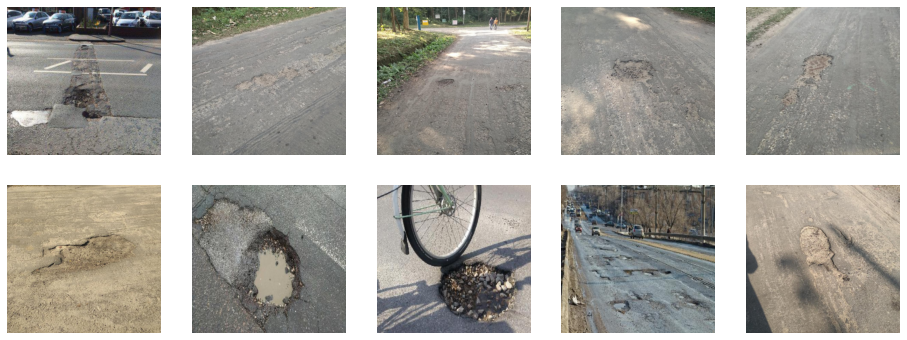

In [14]:
f, ax= plt.subplots(2,5, figsize=(16, 6))

for i, file in enumerate(glob.glob('../input/annotated-potholes-dataset/annotated-images/*.jpg')[:10]):
    ax[i//5][i%5].imshow(load(file), aspect= 'auto')
    ax[i//5][i%5].axis('off')
plt.show()

### Draw B.boxes

In [15]:
def read_content(xml_file: str):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    list_with_all_boxes = []

    for boxes in root.iter('object'):
        filename = root.find('filename').text
        ymin, xmin, ymax, xmax = None, None, None, None
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)

    return filename, list_with_all_boxes

In [16]:
def draw(img, boxes):
    for box in boxes:
        xmin, ymin, xmax, ymax= box
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
    return img

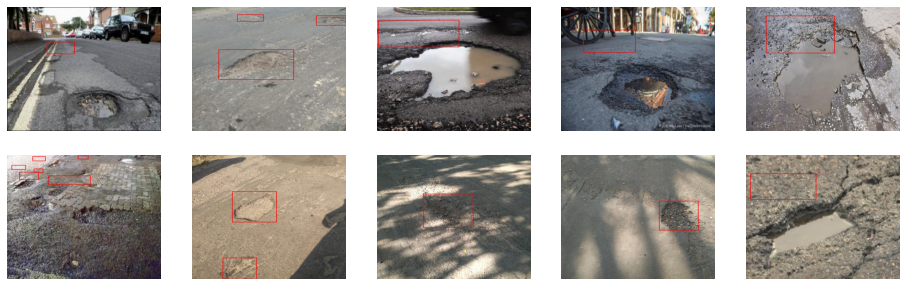

In [17]:
f, ax= plt.subplots(2,5, figsize=(16, 5))

for i, file in enumerate(glob.glob('../input/annotated-potholes-dataset/annotated-images/*.jpg')[-20:-10]):
    img= load(file)
    file_name= os.path.join('../input/annotated-potholes-dataset/annotated-images', file.split('/')[-1][:-4] +'.xml')
    _, boxes= read_content(file_name)
    img= draw(img, boxes)
    
    ax[i//5][i%5].imshow(img, aspect= 'auto')
    ax[i//5][i%5].axis('off')
plt.show()

### Data Pre-Processing

In [18]:
def create_df():
    dic={}
    dic['image_name']=[]
    dic['box']= []
    for xml in (glob.glob('../input/annotated-potholes-dataset/annotated-images/*.xml')):
        name, boxes= read_content(xml)
        name= os.path.join('../input/annotated-potholes-dataset/annotated-images', name)
        for box in boxes:
            dic['image_name'].append(name)
            dic['box'].append(box)
    return pd.DataFrame(dic)

In [19]:
df= create_df()
df.head()

,image_name,box
0,../input/annotated-potholes-dataset/annotated-...,"[163, 205, 245, 243]"
1,../input/annotated-potholes-dataset/annotated-...,"[4, 174, 109, 212]"
2,../input/annotated-potholes-dataset/annotated-...,"[202, 158, 304, 180]"
3,../input/annotated-potholes-dataset/annotated-...,"[314, 189, 360, 206]"
4,../input/annotated-potholes-dataset/annotated-...,"[137, 124, 190, 136]"


In [20]:
df['x_min']= df.box.apply(lambda x: x[0])
df['y_min']= df.box.apply(lambda x: x[1])
df['x_max']= df.box.apply(lambda x: x[2])
df['y_max']= df.box.apply(lambda x: x[3])
df['class_name']= 'pothhole'
df= df.drop(['box'], 1)

In [21]:
df

,image_name,x_min,y_min,x_max,y_max,class_name
0,../input/annotated-potholes-dataset/annotated-...,163,205,245,243,pothhole
1,../input/annotated-potholes-dataset/annotated-...,4,174,109,212,pothhole
2,../input/annotated-potholes-dataset/annotated-...,202,158,304,180,pothhole
3,../input/annotated-potholes-dataset/annotated-...,314,189,360,206,pothhole
4,../input/annotated-potholes-dataset/annotated-...,137,124,190,136,pothhole
...,...,...,...,...,...,...
1735,../input/annotated-potholes-dataset/annotated-...,71,136,236,212,pothhole
1736,../input/annotated-potholes-dataset/annotated-...,264,264,422,435,pothhole
1737,../input/annotated-potholes-dataset/annotated-...,624,68,720,116,pothhole
1738,../input/annotated-potholes-dataset/annotated-...,114,101,310,157,pothhole


### Model Traning

In [22]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 6205 (delta 1), reused 3 (delta 1), pack-reused 6196
Receiving objects: 100% (6205/6205), 13.48 MiB | 7.40 MiB/s, done.
Resolving deltas: 100% (4196/4196), done.


In [ ]:
!conda install -c conda-forge fbprophet

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - fbprophet


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    binutils_impl_linux-64-2.31.1|       h6176602_1         3.9 MB
    binutils_linux-64-2.31.1   |       h6176602_9          26 KB
    ca-certificates-2020.12.5  |       ha878542_0         137 KB  conda-forge
    certifi-2020.12.5          |   py37h89c1867_0         143 KB  conda-forge
    convertdate-2.3.0          |     pyhd8ed1ab_0          36 KB  conda-forge
    ephem-3.7.7.1              |   py37h8f50634_1         765 KB  conda-forge
    fbprophet-0.7.1            |   py37h3340039_0         683 KB  conda-forge
    gcc_impl_linux-64-7.3.0    |       habb00fd_1        41.9 MB
    gcc_linux-64-7.3.0         |       h553295d_9          27 KB
    gxx_impl_linux-64-7.3.0    |       hdf63c60_1        15.0 MB
    gxx_linux

In [24]:
%cd keras-retinanet/
!pip install .

/kaggle/working/keras-retinanet
Processing /kaggle/working/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp37-cp37m-linux_x86_64.whl size=171731 sha256=035b0bad44eeced96199f090aed71d789853ae01efdd36b4c58f9e8eb376d103
  Stored in directory: /root/.cache/pip/wheels/7f/ae/f4/f38a5a29bced2617252cb8aa726369b755c87eeef59fbba1d1
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20487 sha256=fe0f2f6f4df15d9a50586655adeed63379e8108739d851ea9a0e6e651d01261a
  Stored in directory: /root/.cache/pip/wheels/bd/ef/06/5d65f696360436c3a423020c4b7fd8c558c09ef264a0e6c575
Successfully built keras-retinanet keras-resnet


In [25]:
import tensorflow
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr ,preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

import requests
import urllib

In [26]:
df.to_csv('annotations.csv', index=False, header=None)

In [27]:
with open("classes.csv","w") as file:
    file.write("pothhole,0")

In [28]:
PRETRAINED_MODEL = 'snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to snapshots/_pretrained_model.h5


In [29]:
!keras_retinanet/bin/train.py --freeze-backbone \
  --random-transform \
  --weights {PRETRAINED_MODEL} \
  --batch-size 8 \
  --steps 200 \
  --epochs 10 \
  csv annotations.csv classes.csv

2020-12-06 08:57:10.996586: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.2
2020-12-06 08:57:11.002152: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.2
Traceback (most recent call last):
  File "keras_retinanet/bin/train.py", line 34, in <module>
    from .. import layers  # noqa: F401
  File "keras_retinanet/bin/../../keras_retinanet/layers/__init__.py", line 1, in <module>
    from ._misc import RegressBoxes, UpsampleLike, Anchors, ClipBoxes  # noqa: F401
  File "keras_retinanet/bin/../../keras_retinanet/layers/_misc.py", line 20, in <module>
    from ..utils import anchors as utils_anchors
  File "keras_retinanet/bin/../../keras_retinanet/utils/anchors.py", line 20, in <module>
    from ..utils.compute_overlap import compute_overlap
ModuleNotFoundError: No module named 'keras_retinanet.utils.compute_overlap'
